#unzip

In [1]:
!unzip /content/drive/MyDrive/Colab_Notebooks/2023_AIfactory_위성segmentation_202307/정유탱크/oiltank_dataset.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/2023_AIfactory_위성segmentation_202307/정유탱크/oiltank_dataset.zip
   creating: oiltank_dataset/
   creating: oiltank_dataset/valid_images/
  inflating: oiltank_dataset/valid_images/OBJ05625_PS4_K3A_NIA0358.tif  
  inflating: oiltank_dataset/valid_images/OBJ05308_PS3_K3A_NIA0344.kml  
  inflating: oiltank_dataset/valid_images/OBJ03913_PS3_K3A_NIA0165.png  
  inflating: oiltank_dataset/valid_images/OBJ05658_PS3_K3A_NIA0359.kml  
  inflating: oiltank_dataset/valid_images/OBJ05155_PS4_K3A_NIA0336.tif  
  inflating: oiltank_dataset/valid_images/OBJ03972_PS4_K3A_NIA0166.tif  
  inflating: oiltank_dataset/valid_images/OBJ04926_PS3_K3A_NIA0172.png  
  inflating: oiltank_dataset/valid_images/OBJ05436_PS3_K3A_NIA0165.kml  
  inflating: oiltank_dataset/valid_images/OBJ05692_PS4_K3A_NIA0361.tif  
  inflating: oiltank_dataset/valid_images/OBJ05004_PS4_K3A_NIA0328.tif  
  inflating: oiltank_dataset/valid_images/OBJ03156_PS3_K3_NIA0128.png  
  inf

#pip

#get data

In [5]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./visualization_preprocessing/train_data.csv')
train_df

,index,train_data_loc,train_label_xy
0,0,OBJ02634_PS3_K3_NIA0126.png,"[(336.6415449432134, 339.1612715196364), (349...."
1,0,OBJ02634_PS3_K3_NIA0126.png,"[(322.5874084582725, 352.4346226443028), (337...."
2,0,OBJ02634_PS3_K3_NIA0126.png,"[(312.82759145484135, 367.2695444895181), (329..."
3,0,OBJ02634_PS3_K3_NIA0126.png,"[(287.8424599260575, 390.3027126176158), (301...."
4,0,OBJ02634_PS3_K3_NIA0126.png,"[(305.41013053223367, 394.59703209912556), (32..."
...,...,...,...
1005,67,OBJ05733_PS3_K3A_NIA0363.png,"[(946.3780053972047, 128.88179847646327), (959..."
1006,68,OBJ05760_PS3_K3A_NIA0365.png,"[(578.1284550609116, 225.30518552949212), (593..."
1007,69,OBJ05781_PS3_K3A_NIA0368.png,"[(86.25686800677065, 264.84640029489117), (98...."
1008,69,OBJ05781_PS3_K3A_NIA0368.png,"[(109.66569892916438, 271.8905213728775), (121..."


#dataset class

In [6]:
import ast

"""
csv 파일에서 해당하는 index에 해당하는 bounding box들을 [[x1,y1,x2,y2],[x1,y1,x2,y2]]형태로 반환
"""
def translate_points(csv,idx,is_xywh=False, img_size=1024):

  labels = csv['train_label_xy'][csv['index']==idx].values

  len_list = len(labels)
  bbox_list = []

  for xy_string in labels:
    train_xy = ast.literal_eval(xy_string)

    x_coords = [coord[0] for coord in train_xy]
    y_coords = [coord[1] for coord in train_xy]

    if(is_xywh):
      bounding_box = [min(x_coords), min(y_coords), max(x_coords)-min(x_coords), max(y_coords)-min(y_coords)]
    else:
      bounding_box = [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

    bbox = bounding_box

    bbox_list.append(bbox)

  return bbox_list , len_list

In [7]:
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
import torch
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image

class OilTankDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, csv, split, transforms,img_size=1024):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        """
        self.transforms = transforms

        self.split = split.upper()

        assert self.split in {'TRAIN', 'VALIDATION','TEST'}

        self.csv = csv
        self.img_size = img_size

        # Read data files

        train_images_dir = "/content/oiltank_dataset/train_images/" #unzip해서 하기때문에 파일 주소는 고정
        train_images_path = os.listdir(train_images_dir)
        train_images_path = [file for file in train_images_path if file.endswith('.png')]
        train_images_path = sorted(train_images_path)

        vali_images_dir = "/content/oiltank_dataset/valid_images/"
        vali_images_path = os.listdir(vali_images_dir)
        vali_images_path = [file for file in vali_images_path if file.endswith('.png')]
        vali_images_path = sorted(vali_images_path)


        if (self.split=='TRAIN'):
          self.images = train_images_path[5:]
          self.path = 'train_images/'
        elif (self.split=='VALIDATION'):
          self.images = train_images_path[:5] #일단은 앞 5개 validation set으로, 추후 수정
          self.path = 'train_images/'
        else:
          self.images = vali_images_path
          self.path = 'valid_images/'


    def __getitem__(self, i):
            # Read image
        image = Image.open(os.path.join(f'/content/oiltank_dataset/{self.path}',self.images[i]), mode='r')
        image = image.convert('RGB')


        if(self.split=='TEST'):
          image = image #transform
          return image, [], []

        boxes, len_labels = translate_points(self.csv,i)
        labels = np.ones(len_labels) #label하나므로 싹다 1

        masks = np.zeros((self.img_size, self.img_size))
        for box in boxes:
          masks[int(box[0]):int(box[1]),int(box[2]):int(box[3])]=1
          # making the points inside the bbox as 1(works as a mask)

        #bbox=[]
        #for k in bounding_box:
        #  bbox.append(k/img_size)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((len_labels,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([i])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((len_labels,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.images)

#dataloader

In [8]:
import random
import torch

from torchvision.transforms import functional as F

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [9]:


def get_transform(train):
    transforms = []
    transforms.append(ToTensor())

    return Compose(transforms)

In [10]:
train_dataset = OilTankDataset(train_df,'TRAIN',get_transform(train=True))
validation_dataset = OilTankDataset(train_df,'VALIDATION',get_transform(train=False))
test_dataset = OilTankDataset(train_df,'TEST',get_transform(train=False))

validation_dataset[1]
test_dataset[1]
train_dataset[1] #images, boxes, labels, difficulties


(tensor([[[0.0980, 0.0980, 0.1059,  ..., 0.2000, 0.2118, 0.2118],
          [0.0902, 0.0863, 0.1059,  ..., 0.2039, 0.2157, 0.2157],
          [0.0980, 0.1176, 0.1137,  ..., 0.1922, 0.1922, 0.2039],
          ...,
          [0.2275, 0.2353, 0.1843,  ..., 0.0784, 0.0863, 0.0902],
          [0.2000, 0.2078, 0.2118,  ..., 0.0902, 0.0902, 0.0863],
          [0.2196, 0.2000, 0.2353,  ..., 0.1137, 0.0941, 0.0863]],
 
         [[0.0902, 0.0941, 0.1020,  ..., 0.1882, 0.1961, 0.2000],
          [0.0824, 0.0824, 0.0980,  ..., 0.1922, 0.2039, 0.2039],
          [0.0941, 0.1098, 0.1059,  ..., 0.1843, 0.1843, 0.1922],
          ...,
          [0.2078, 0.2078, 0.1608,  ..., 0.0824, 0.0902, 0.0902],
          [0.1804, 0.1843, 0.1843,  ..., 0.0941, 0.0902, 0.0863],
          [0.2000, 0.1765, 0.2039,  ..., 0.1098, 0.0941, 0.0824]],
 
         [[0.0784, 0.0784, 0.0863,  ..., 0.1725, 0.1804, 0.1843],
          [0.0706, 0.0706, 0.0863,  ..., 0.1765, 0.1882, 0.1843],
          [0.0824, 0.0980, 0.0941,  ...,

In [74]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 8
workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                                              collate_fn=collate_fn,  num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                               collate_fn=collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

#criterion & model

In [94]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [95]:
#model

#train

##utils

In [78]:
from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


##.train

In [103]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [79]:
import math
import sys

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [96]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2

    # define training and validation data loaders
    data_loader = train_loader

    data_loader_test = validation_loader

    # get the model using our helper function
    #model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params,lr=0.001,weight_decay=1e-5)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.5)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        #evaluate(model, data_loader_test, device=device)

    print("That's it!")

if __name__ == "__main__":
    main()

Epoch: [0]  [0/9]  eta: 0:00:27  lr: 0.000126  loss: 3.4395 (3.4395)  loss_classifier: 0.5013 (0.5013)  loss_box_reg: 0.0238 (0.0238)  loss_objectness: 2.7618 (2.7618)  loss_rpn_box_reg: 0.1525 (0.1525)  time: 3.0380  data: 1.4583  max mem: 12958
Epoch: [0]  [8/9]  eta: 0:00:01  lr: 0.001000  loss: 1.4951 (2.0215)  loss_classifier: 0.2461 (0.3197)  loss_box_reg: 0.0337 (0.0398)  loss_objectness: 0.7282 (1.4217)  loss_rpn_box_reg: 0.2311 (0.2402)  time: 1.6529  data: 0.1633  max mem: 12958
Epoch: [0] Total time: 0:00:14 (1.6638 s / it)
Epoch: [1]  [0/9]  eta: 0:00:30  lr: 0.001000  loss: 1.4996 (1.4996)  loss_classifier: 0.2026 (0.2026)  loss_box_reg: 0.1141 (0.1141)  loss_objectness: 1.0230 (1.0230)  loss_rpn_box_reg: 0.1600 (0.1600)  time: 3.3732  data: 1.6322  max mem: 12958
Epoch: [1]  [8/9]  eta: 0:00:01  lr: 0.001000  loss: 1.2175 (1.3235)  loss_classifier: 0.1700 (0.1882)  loss_box_reg: 0.0266 (0.0388)  loss_objectness: 0.6653 (0.7138)  loss_rpn_box_reg: 0.2610 (0.3828)  time: 1.

tensor([681.2368, 247.5380, 699.5366, 271.7215], device='cuda:0') tensor(0.1062, device='cuda:0')
tensor([747.8359, 544.8842, 766.0768, 568.0923], device='cuda:0') tensor(0.1049, device='cuda:0')
tensor([742.6907, 550.0079, 761.0025, 573.2367], device='cuda:0') tensor(0.1045, device='cuda:0')
tensor([752.9828, 539.8271, 771.1943, 562.8786], device='cuda:0') tensor(0.1045, device='cuda:0')
tensor([445.7770, 626.5243, 464.0637, 650.7284], device='cuda:0') tensor(0.1042, device='cuda:0')
tensor([758.0920, 534.6558, 776.3025, 557.7893], device='cuda:0') tensor(0.1042, device='cuda:0')
tensor([676.1140, 242.3682, 694.4827, 266.8404], device='cuda:0') tensor(0.1041, device='cuda:0')
tensor([747.8413, 555.0838, 766.1091, 578.4542], device='cuda:0') tensor(0.1036, device='cuda:0')
tensor([763.1909, 529.4547, 781.4337, 552.7850], device='cuda:0') tensor(0.1035, device='cuda:0')
tensor([752.9700, 549.9688, 771.2643, 573.3771], device='cuda:0') tensor(0.1034, device='cuda:0')
tensor([256.3409, 75

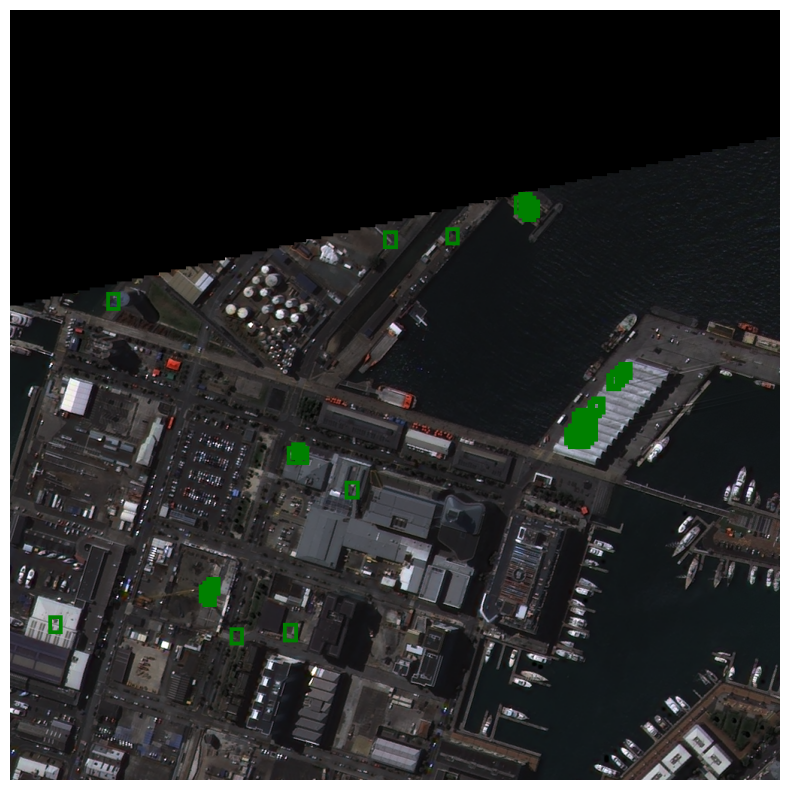

In [102]:
#####
# check for validation/train dataset
#####


import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

user_index = 0
img, _ = validation_dataset[user_index]
#img, _ = train_dataset[user_index]


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# pick one image from the test set

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])


bboxes = []
for bx, sc in zip(prediction[0]['boxes'],prediction[0]['scores']):
  if(sc<0.1):
    continue
  print(bx,sc)
  bboxes.append(bx.cpu().tolist())

img = img.mul(255).permute(1, 2, 0).byte().numpy()
img = Image.fromarray(img)

plt.figure(figsize=(10, 10))  # 그림 크기 조정
plt.axis('off')

draw = ImageDraw.Draw(img)

for box in bboxes:
  print([box[0],box[1],box[2],box[3]])
  draw.rectangle([box[0],box[1],box[2],box[3]],outline='green',width=5)

plt.imshow(img)

#기타

In [ ]:
from PIL import Image

train_img = Image.open('/content/oiltank_dataset/train_images/OBJ02634_PS3_K3_NIA0126.png')

test_img = Image.open('/content/oiltank_dataset/valid_images/OBJ00028_PS3_K3_NIA0078.png')

print(f"train image size: {train_img.width,train_img.height}")
print(f"test image size: {test_img.width,test_img.height}")

train image size: (1024, 1024)
test image size: (1024, 1024)
